**Implementing FIR filters**

In real time filtering applications, filter are implemented by using some variation or other of their constant coefficient difference equation, so that one new output sample is generated for each new input sample. If all the input data is available in advance, as in non-real-time(aka "öffline") applications, then the CCDE based algorithm is iteratively applied to all samples in the buffer.

In the case of FIR filters, the CCDE coefficients correspond to impulse response and implementing the CCDE is equivalent to performing a convolution sum. In this notebook we will look at different ways to implement FIR filters

In [20]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

**Online Implementation**

The classic way to implement a filter is one-in one-out approach. We will need to implement a persistant delay line. In python we can either define a class or use function attributes; classes are tidier and reusable:

In [21]:
class FIR_loop():
    def __init__(self, h):
        self.h = h
        self.ix = 0
        self.M = len(h)
        self.buf = np.zeros(self.M)
    
    def filter(self, x):
        y=0
        self.buf[self.ix]=x
        for n in range(0, self.M):
            y+=self.h[n]*self.buf[(self.ix+self.M-n) % self.M]
        self.ix = (self.ix+1)%self.M
        return y

In [22]:
# simple moving average:
h = np.ones(5)/5
f = FIR_loop(h)
for n in range(0,10):
    print(f.filter(n), end=", ")

0.0, 0.2, 0.6000000000000001, 1.2, 2.0000000000000004, 3.0000000000000004, 4.0, 5.0, 6.0, 7.000000000000001, 

While there's nothing wrong with the above implementation, when the data to be filtered is known in advance, it makes no sense to explicitly iterate over its element and it's better to use higher-level commands to perform the convolution. In Numpy, the command is convolve; before we use it, though, we need to take border effects into consideration.

signal length:  21


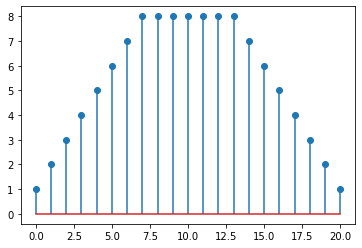

In [23]:
# lets use a simple moving average:
M= 5
h = np.ones(M)/float(M)

# lets build a signal with a ramp and a plateau
x = np.concatenate((np.arange(1, 9), np.ones(5)*8, np.arange(8,0,-1)))

plt.stem(x, use_line_collection=True);

print("signal length: ", len(x))

**1) NO BORDER EFFECTS**

We may chosse to accept the loss of data points and use only the N-M+1 output samples that correspond to full overlap between the input data and impulse response. This can be achieved by selecting mode='Valid' in correlate:

signal length:  17


<StemContainer object of 3 artists>

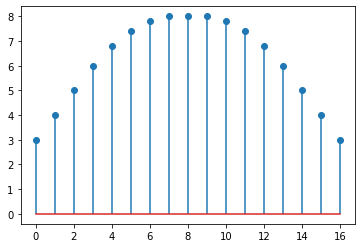

In [24]:
y = np.convolve(x, h, mode = 'valid')
print("signal length: ", len(y))
plt.stem(y, use_line_collection=True)

**2) Finite-support extension**

BY embedding the input into a finite support signal, the convolution sum is now well defined for all values of n, which now creates a new problem: the output will be nonzero for all values of n for which x[n-k] is nonzero,that is for 0<=n<= N+M-1: we end up with a longer support for output sequence. This is the default in correlate and corresponds to mode 'full':

signal length:  25


<StemContainer object of 3 artists>

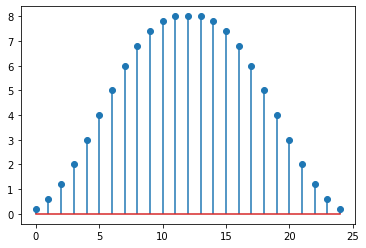

In [25]:
y = np.convolve(x, h, mode = 'full')
print("signal length: ", len(y))
plt.stem(y, use_line_collection=True)

If you want to preserve the same length for input and output, we need to truncate the result. You can keep the first N samples and discard the tail; this corresponds to online implementation of FIR filter. Alternatively you can discard half the extra samles from beginning and half from end of the output and distribute the border effect evenly; This si achieved in correlate by setting mode = 'same:'

signal length:  21


<StemContainer object of 3 artists>

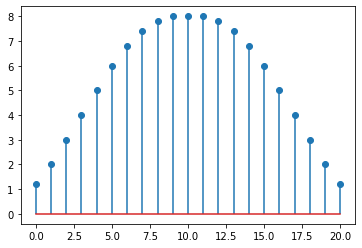

In [26]:
y = np.convolve(x, h, mode = 'same')
print("signal length: ", len(y))
plt.stem(y, use_line_collection=True)

**3) Periodic extension**

As we know, the other way of embedding a finite-length signal is to build a periodic extension. The convolution in this case will return an  NN -periodic output:

ỹ [n]=∑k=0M−1h[k]x̃ [n−k]

 
We can easily implement a circular convolution using convolve like so: since the overlap between time-reversed impulse response and input is already good for the last  N−MN−M  points in the output, we just need to consider two periods of the input to compute the first  M :

In [27]:
def cconv(x, h):
    # as before, we assume len(h)<len(x)
    L = len(x)
    xp = np.concatenate((x,x))
    # full convolution
    y = np.convolve(xp, h)
    return y[L:2*L]

signal length:  21


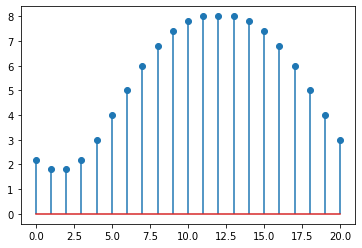

In [28]:
y = cconv(x, h)
print('signal length: ', len(y))
plt.stem(y, use_line_collection=True);


OK, clearly the result is not necessarily what we expected; note however that in both circular and "normal" convolution, you still have M−1 output samples "touched" by border effects, it's just that the border effects act differently in the two cases.

Interestingly, you can still obtain a "normal" convolution using a circular convolution if you zero-pad the input signal with M−1 zeros:

signal length:  25


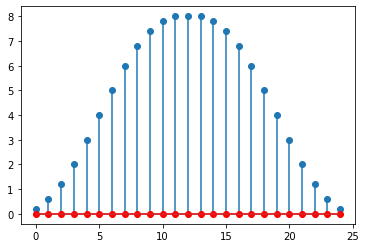

In [29]:
y = cconv(np.concatenate((x, np.zeros(M-1))),h)
print("signal length: ", len(y))
plt.stem(y, use_line_collection=True);

# plot in red the difference with standard conv
plt.stem(y- np.convolve(x, h, mode = 'full'), markerfmt = 'ro', use_line_collection=True);



Why is this interesting? Because of DFT

**Offline implementation of DFT**

The undamental result is: The inverse DFT of the product of two DFTs is the circular convolution of underlying time domain sequences!

To apply this result to FIR filtering, the first step is to choose the space for the DFTs. In our case we have a finite-length data vector of length  N  and a finite-support impulse response of length  M  with  M<N  so let's operate in  ℂN by zero-padding the impulse response to size  N. Also, we most likely want the normal convolution, so let's zero-pad both signals by an additional  M−1 samples

In [30]:
def DFTconv(x, h, mode = 'full'):
    # we want to compute full convolution
    N = len(x)
    M = len(h)
    X = np.fft.fft(x, n = N+M-1)
    H = np.fft.fft(h, n = N+M-1)
    # we are using real - valued signals,
    # so drop the imag part
    y = np.real(np.fft.ifft(X*H))
    if mode == 'valid':
        # only N-M+1 points, starting at M-1
        return y [M-1:N]
    elif mode == 'same':
        return y[int((M-1)/2):int((M-1)/2)+N]
    else:
        return y

Let's verify that the results are the same

signal length:  17
signal length:  17


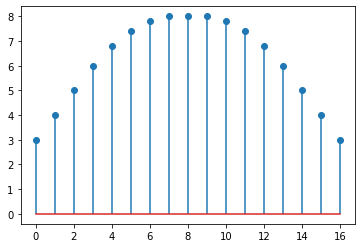

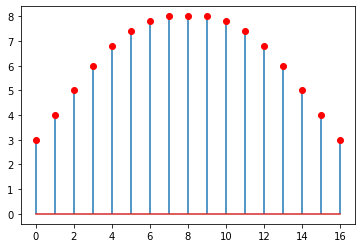

In [31]:
y = np.convolve(x, h, mode='valid')
print('signal length: ', len(y))
plt.stem(y, use_line_collection=True);
plt.figure()
y = DFTconv(x, h, mode='valid')
print('signal length: ', len(y))
plt.stem(y, markerfmt='ro', use_line_collection=True);

signal length:  21
signal length:  21


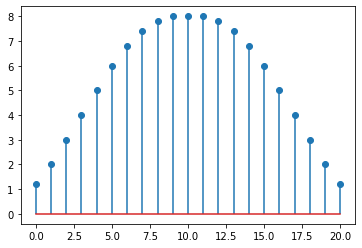

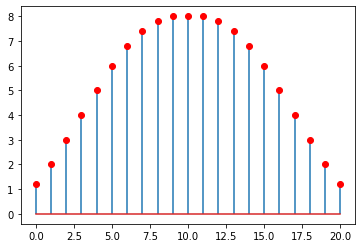

In [32]:
y = np.convolve(x, h, mode='same')
print('signal length: ', len(y))
plt.stem(y, use_line_collection=True);
plt.figure()
y = DFTconv(x, h, mode='same')
print('signal length: ', len(y))
plt.stem(y, markerfmt='ro', use_line_collection=True);

Of course the question at this point is: why go through the trouble of taking DFTs if all we want is the standard convolution? The answer is: computational efficiency.

If you look at the convolution sum, each output sample requires  M  multiplications (and  M−1 additions but let's just consider multiplications). In order to filter an  N -point signal we will need  NM  multiplications. Assume  N≈M  and you can see that the computational requirements are on the order of  M2. If we go the DFT route using an efficient FFT implementation we have approximately:

Mlog2M  multiplication to compute  H[k]

Mlog2M multiplication to compute  X[k] 

Mlog2M multiplication to compute  X[k]H[k] 

Mlog2M  multiplication to compute the inverse DFT

Even considering that we now have to use complex multiplications (which will cost twice as much), we can estimate the cost of the DFT based convolution at around  8Mlog2M , which is smaller than  M2  as soon as  M>44

In practice, the data vector is much longer than the impulse response so that filtering via standard convolution requires on the order of  MN  operations. Two techniques, called Overlap Add and Overlap Save can be used to divide the convolution into  N/M independent convolutions between  h[n]  and an  M -sized piece of  x[n] ; FFT-based convolution can then be used on each piece. While the exact cost per sample of each technique is a bit complicated to estimate, as a rule of thumb as soon as the impulse response is longer than 50 samples, it's more convenient to use DFT-based filtering.